Adding information soon

To upload a copy to GitHub:
File > Save a copy in Github > Choose the v2 repo

In [ ]:
############ TO FIX / TO DO:

# OUTLIERS on ALL metrics, not just one column (input AND output)

# replace old outcomes dataframe in cleaning step with the new one in preprocessing step

# **Data Source and Project Description**

Info goes here :)

# **Initial Data Processing**

Citations:

**Importing Packages**

In [1]:
# basic libraries

import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import statistics as stats
import seaborn as sns

# modeling libraries (some may not be needed, this is to try everything out)

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import statsmodels.api as sm
import statsmodels.formula.api as smformula
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from scipy import stats
from statsmodels.othermod.betareg import BetaModel, BetaResults
from statsmodels.genmod.families.links import identity
import patsy
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.gofplots import qqplot
from scipy.stats.distributions import norm

**Importing Data**

Data source: XYZ

In [ ]:
# allow access to Google Drive
# click "yes" on the account that has the data you want to import
from google.colab import drive
drive.mount('/content/drive')

In [4]:
# importing data as a loop instead

transplant_data = pd.read_excel('/content/drive/MyDrive/Organ_Donation_and_Transplantation_Data.xlsx', sheet_name = None)
transplant_frames = {}
for key, value in transplant_data.items():
    strippedkey = key.replace(' ','').replace('-','_').lower()
    transplant_frames[strippedkey] = value

# access each df (example)
transplant_frames['otcoutcomemeasures']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,OTC_Name_State,Type,Organ Transplanted,Percent of Transplants with Functioning Graft at 30 Days,Percent of Transplants with Functioning Graft at 1 year,Percent of Patients Alive at 30 Days,Percent of Patients Alive at 1 Year,Last Refresh Date,Date Range for Data - Start,Date Range for Data - End
0,Children's of Alabama (AL),Deceased Donor - Heart,Heart,100.00%,100.00%,100.00%,100.00%,"December 16, 2024","January 1, 2019","August 31, 2023"
1,Children's of Alabama (AL),Deceased Donor - Kidney,Kidney,100.00%,97.22%,100.00%,100.00%,"December 16, 2024","January 1, 2019","August 31, 2023"
2,Children's of Alabama (AL),Deceased Donor - Liver,Liver,94.12%,88.24%,94.12%,88.24%,"December 16, 2024","January 1, 2019","August 31, 2023"
3,Children's of Alabama (AL),Living Donor - Kidney,Kidney,100.00%,100.00%,100.00%,100.00%,"December 16, 2024","January 1, 2019","August 31, 2023"
4,University of Alabama Hospital (AL),Deceased Donor - Heart,Heart,98.04%,91.09%,99.02%,91.09%,"December 16, 2024","January 1, 2019","August 31, 2023"
...,...,...,...,...,...,...,...,...,...,...
1139,University of Wisconsin Hospital and Clinics (WI),Living Donor - Liver,Liver,100.00%,87.50%,100.00%,87.50%,"December 16, 2024","January 1, 2019","August 31, 2023"
1140,Charleston Area Medical Center (WV),Deceased Donor - Kidney,Kidney,97.07%,88.58%,97.56%,90.82%,"December 16, 2024","January 1, 2019","August 31, 2023"
1141,Charleston Area Medical Center (WV),Living Donor - Kidney,Kidney,95.24%,93.33%,95.24%,93.33%,"December 16, 2024","January 1, 2019","August 31, 2023"
1142,West Virginia University Hospitals Inc. (WV),Deceased Donor - Heart,Heart,100.00%,96.88%,100.00%,96.88%,"December 16, 2024","January 1, 2019","August 31, 2023"


**Cleaning Data**

In [56]:
# we can -technically- make all of this into a single function. I might do that later -cb
# National Overview ############################################################
clean_overview = transplant_frames['overview_national'].copy()
clean_overview.isna().any()

#stripping the whitespace
clean_overview['Number of deceased organ donors recovered'] = clean_overview['Number of living organ donors recovered'].str.strip()
clean_overview['Number of living organ donors recovered'] = clean_overview['Number of living organ donors recovered'].str.strip()

#removing the . and suppressed values
clean_overview = clean_overview.replace({'.':np.nan, 'Suppressed':np.nan})

#dropping rows with missing values
clean_overview= clean_overview.dropna()

#converting columns to integer/datetime format/category
clean_overview = clean_overview.astype({'Number of deceased organ donors recovered':'int64',
                                        'Number of living organ donors recovered':'int64',
                                        'Number of living donor organ transplant recipients':'int64',
                                        'Organ': 'category',
                                        'Last Refresh Date' : 'datetime64[ns]',
                                        'Date Range for Data - Start' : 'datetime64[ns]',
                                        'Date Range for Data - End' : 'datetime64[ns]'})


# State Overview ###############################################################
clean_overview_state = transplant_frames['overview_state'].copy()
clean_overview_state.isna().any()
clean_overview_state = clean_overview_state.replace({'.':np.nan, 'Suppressed':np.nan})
clean_overview_state = clean_overview_state.dropna()

clean_overview_state = clean_overview_state.astype({'Year':'category',
                                        'State of Residence Name':'category',
                                        'State of Residence Code':'category',
                                        'Organ': 'category',
                                        'counts' : 'int64',
                                        'Last Refresh Date' : 'datetime64[ns]',
                                        'Date Range for Data - Start' : 'datetime64[ns]',
                                        'Date Range for Data - End' : 'datetime64[ns]'})

# Donor Demographics ###########################################################
clean_demographics = transplant_frames['donordemographics'].copy()
# extracting first letter of category
clean_demographics['Category Code'] = clean_demographics['Category'].astype('str').str[0]
# removing '.' and suppressed
clean_demographics = clean_demographics.replace({'.': np.nan, 'Suppressed': np.nan})
clean_demographics = clean_demographics.dropna()
clean_demographics = clean_demographics.astype({'Category' : 'category',
                                                'Donor Type Filter' : 'category',
                                                'Level' : 'category',
                                                'Donor Count' : 'int64',
                                                'Last Refresh Date' : 'datetime64[ns]',
                                                'Date Range for Data - Start' : 'datetime64[ns]',
                                                'Date Range for Data - End' : 'datetime64[ns]',
                                                'Category Code' : 'category'})


# OPO - POTR ###################################################################
clean_opo = transplant_frames['opo_potr'].copy()
clean_opo['Procured Organ Transplant Rate'] = clean_opo['Procured Organ Transplant Rate'].astype('str').str.strip("%").str.strip()
clean_opo = clean_opo.replace({'.':np.nan, 'Suppressed':np.nan})
clean_opo = clean_opo.dropna()
clean_opo = clean_opo.astype({'OPO Name (State)' : 'category',
                                                'Year' : 'category',
                                                'Organ' : 'category',
                                                'Procured Organ Transplant Rate' : 'float64',
                                                'Last Refresh Date' : 'datetime64[ns]',
                                                'Date Range for Data - Start' : 'datetime64[ns]',
                                                'Date Range for Data - End' : 'datetime64[ns]'})

# OPO Service Area by County ###################################################

clean_service_area = transplant_frames['oposerviceareabycounty'].copy()
clean_service_area = clean_service_area.replace({'.':np.nan, 'Suppressed':np.nan})
clean_service_area  = clean_service_area.dropna()
#i moved the replace and drop up here
clean_service_area['State'] = clean_service_area['OPO Name (State)'].astype('str').str[-4:].str.strip('()')
clean_service_area['OPO'] = clean_service_area['OPO Name (State)'].astype('str').str[:-4]

# extract state last 2 letter code
clean_service_area['State'] = clean_service_area['OPO Name (State)'].astype(str).str[-3:-1]
#extract OPO from OPO Name everything before the last 4 characters
clean_service_area['OPO'] = clean_service_area['OPO Name (State)'].astype(str).str[:-4]
clean_service_area = clean_service_area.astype({'OPO Name (State)' : 'category',
                                                'County FIPS' : 'int64',
                                                'FIPS State Name' : 'category',
                                                'FIPS County Name' : 'category',
                                                'Service Area Overlap with' : 'category',
                                                'Last Refresh Date' : 'datetime64[ns]',
                                                'Date Range for Data - Start' : 'datetime64[ns]',
                                                'Date Range for Data - End' : 'datetime64[ns]',
                                                'State' : 'category',
                                                'OPO' : 'category'})


# Waitlist-Candidate Registration ##############################################

clean_waitcand = transplant_frames['waitlist_candidateregistration'].copy()
clean_waitcand = clean_waitcand.replace({'.':np.nan, 'Suppressed':np.nan})
clean_waitcand = clean_waitcand.dropna()
clean_waitcand = clean_waitcand.astype({'Candidate/Registration' : 'category',
                                        'Year of Addition' : 'category',
                                        'Organ Type' : 'category',
                                        'Total' : 'int64',
                                        'Sex: Female' : 'category',
                                        'Sex: Male' : 'category',
                                        'Race: White, Non-Hispanic' : 'int64',
                                        'Race: Black, Non-Hispanic' : 'int64',
                                        'Race: Asian, Non-Hispanic' : 'int64',
                                        'Race: Hispanic/Latino' : 'int64',
                                        'Race: Amer Ind/Alaska Native, Non-Hispanic' : 'int64',
                                        'Race: Native Hawaiian/other Pacific Islander, Non-Hispanic' : 'int64',
                                        'Race: Multiracial, Non-Hispanic' : 'int64',
                                        'Primary Payment: Medicare Advantage' : 'int64',
                                        'Primary Payment: Medicare FFS' : 'int64',
                                        'Primary Payment: Medicaid & CHIP' : 'int64',
                                        'Primary Payment: Other' : 'int64',
                                        'Primary Payment: Private' : 'int64',
                                        'Age Group: Pediatric' : 'int64',
                                        'Age Group: 18-30' : 'int64',
                                        'Age Group: 31-40' : 'int64',
                                        'Age Group: 41-50' : 'int64',
                                        'Age Group: 51-60' : 'int64',
                                        'Age Group: 61+' : 'int64',
                                        'Last Refresh Date' : 'datetime64[ns]',
                                        'Date Range for Data - Start' : 'datetime64[ns]',
                                        'Date Range for Data - End' : 'datetime64[ns]'})

# Waitlist-OTC Transplant Rate #################################################
clean_waittransplant = transplant_frames['waitlist_otctransplantrate'].copy()
clean_waittransplant = clean_waittransplant.astype({'Percent of Deceased Donor Transplant with 1 Year' : 'str',
                                                   'Percent of Deceased Donor Transplant with 2 Years' : 'str',
                                                    'Percent of Deceased Donor Transplant with 30 Days' : 'str',
                                                    'Percent of Deceased Donor Transplant with 3 Years' : 'str'})

to_fix = clean_waittransplant[['Percent of Deceased Donor Transplant with 1 Year',
                               'Percent of Deceased Donor Transplant with 2 Years',
                               'Percent of Deceased Donor Transplant with 30 Days',
                               'Percent of Deceased Donor Transplant with 3 Years']]

clean_waittransplant[to_fix.columns] = to_fix.apply(lambda x: x.str.strip('%').str.strip())

clean_waittransplant['State'] = clean_waittransplant['Transplant Center (State)'].astype('str').str[-4:].str.strip('()')
clean_waittransplant['Transplant Center'] = clean_waittransplant['Transplant Center (State)'].astype('str').str[:-4]
clean_waittransplant = clean_waittransplant.replace({'.':np.nan, 'Suppressed':np.nan})
clean_waittransplant = clean_waittransplant.dropna()

clean_waittransplant = clean_waittransplant.astype({'Transplant Center (State)' : 'category',
                                        'Organ Type' : 'category',
                                        'Percent of Deceased Donor Transplant with 30 Days' : 'float64',
                                        'Percent of Deceased Donor Transplant with 1 Year' : 'float64',
                                        'Percent of Deceased Donor Transplant with 2 Years' : 'float64',
                                        'Percent of Deceased Donor Transplant with 3 Years' : 'float64',
                                        'Last Refresh Date' : 'datetime64[ns]',
                                        'Date Range for Data - Start' : 'datetime64[ns]',
                                        'Date Range for Data - End' : 'datetime64[ns]',
                                        'State' : 'category',
                                        'Transplant Center' : 'category'})

# Waitlist-OTC Removal Reasons #################################################
clean_removal = transplant_frames['waitlist_otcremovalreasons'].copy()
clean_removal = clean_removal.replace({'.':np.nan, 'Suppressed':np.nan})
clean_removal = clean_removal .dropna()
clean_removal['State'] = clean_removal['Transplant Center (State)'].astype('str').str[-4:].str.strip('()')
clean_removal['Transplant Center'] = clean_removal['Transplant Center (State)'].astype('str').str[:-4]
clean_removal = clean_removal.astype({'Transplant Center (State)' : 'category',
                                        'Organ Type' : 'category',
                                        'Transferred to Another Center' : 'int64',
                                        'Received Living Donor Transplant' : 'int64',
                                        'Received Living Donor Transplant' : 'int64',
                                        'Died' : 'int64',
                                        'Received Transplant Elsewhere' : 'int64',
                                        'Too sick for Transplant' : 'int64',
                                        'Recovered without Transplant' : 'int64',
                                        'Other Reasons' : 'int64',
                                        'Last Refresh Date' : 'datetime64[ns]',
                                        'Date Range for Data - Start' : 'datetime64[ns]',
                                        'Date Range for Data - End' : 'datetime64[ns]',
                                        'State' : 'category',
                                        'Transplant Center' : 'category'})
#clean_removal.head()

# Recipient Demographics #######################################################
clean_recipient_demographics = transplant_frames['recipientdemographics'].copy()
clean_recipient_demographics = clean_recipient_demographics.replace({'.':np.nan, 'Suppressed':np.nan})
clean_recipient_demographics = clean_recipient_demographics.dropna()
clean_recipient_demographics = clean_recipient_demographics.astype({'Transplant Year' : 'category',
                                                                    'Donor Type' : 'category',
                                                                    'Organ Transplanted' : 'category',
                                                                    'Total Distinct Recipients' : 'int64',
                                                                    'Male Distinct Recipients' : 'int64',
                                                                    'Female Distinct Recipients' : 'int64',
                                                                    'Distinct Recipients with Age Not Reported' : 'int64',
                                                                    'Pediatric Distinct Recipients' : 'int64',
                                                                    'Age 18-30 Distinct Recipients' : 'int64',
                                                                    'Age 31-40 Distinct Recipients' : 'int64',
                                                                    'Age 41-50 Distinct Recipients' : 'int64',
                                                                    'Age 51-60 Distinct Recipients': 'int64',
                                                                    'Age 61+ Distinct Recipients' : 'int64',
                                                                    'White Distinct Recipients' : 'int64',
                                                                    'Black Distinct Recipients' : 'int64',
                                                                    'Hispanic Distinct Recipients' : 'int64',
                                                                    'Asian Distinct Recipients' : 'int64',
                                                                    'American Indian Distinct Recipients' : 'int64',
                                                                    'Native Hawaiian Distinct Recipients' : 'int64',
                                                                    'Multiracial Distinct Recipients' : 'int64',
                                                                    'Distinct Recipients with Medicare Advantage Payment Source' : 'int64',
                                                                    'Distinct Recipients with Private Insurance Payment Source' : 'int64',
                                                                    'Distinct Recipients with Medicare FFS Payment Source' : 'int64',
                                                                    'Distinct Recipients with Medicaid and CHIP Payment Source' : 'int64',
                                                                    'Distinct Recipients with Other Insurance Payment Sources' : 'int64',
                                                                    'Last Refresh Date' : 'datetime64[ns]',
                                                                    'Date Range for Data - Start' : 'datetime64[ns]',
                                                                    'Date Range for Data - End' : 'datetime64[ns]'})

#clean_recipient_demographics.head()

# OTC Transplants by Demographics #######################################################
# this one has 'all centers' listed in it, so we must remove those columns first
clean_transplant_demographics = transplant_frames['otctransplantsbydemographics'].copy()
clean_transplant_demographics['OTC_Name_State'] = clean_transplant_demographics['OTC_Name_State'].astype('category')

demo_filter = clean_transplant_demographics['OTC_Name_State'].isin(['(All Centers)'])
clean_filtered_transplant_demographics = clean_transplant_demographics[~demo_filter]
demo_filter2 = clean_transplant_demographics[clean_transplant_demographics['OTC_Name_State'].isin(['(All Centers)'])]
demo_filter2['State'] = "None"
demo_filter2['OTC Name'] = "None"

clean_filtered_transplant_demographics['State'] = clean_filtered_transplant_demographics['OTC_Name_State'].astype('str').str[-4:].str.strip('()')
clean_filtered_transplant_demographics['OTC Name'] = clean_filtered_transplant_demographics['OTC_Name_State'].astype('str').str[:-4]

clean_filtered_transplant_demographics2 = pd.concat([clean_filtered_transplant_demographics, demo_filter2])
clean_filtered_transplant_demographics2 = clean_filtered_transplant_demographics2.replace({'.':np.nan, 'Suppressed':np.nan})
clean_filtered_transplant_demographics2 = clean_filtered_transplant_demographics2.dropna()

clean_filtered_transplant_demographics2 = clean_filtered_transplant_demographics2.astype({'OTC_Name_State' : 'category',
                                                                    'Donor Type' : 'category',
                                                                    'Organ Transplanted' : 'category',
                                                                    'Total Transplants' : 'int64',
                                                                    'Transplants with Male Recipients' : 'int64',
                                                                    'Transplants with Female Recipients' : 'int64',
                                                                    'Pediatric Transplants' : 'int64',
                                                                    'Transplants with Recipients Age 18-30' : 'int64',
                                                                    'Transplants with Recipients Age 31-40' : 'int64',
                                                                    'Transplants with Recipients Age 41-50' : 'int64',
                                                                    'Transplants with Recipients Age 51-60': 'int64',
                                                                    'Transplants with Recipients Age 61+' : 'int64',
                                                                    'Transplants with Recipients Age Not Reported' : 'int64',
                                                                    'White Recipient Transplants' : 'int64',
                                                                    'Black Recipient Transplants' : 'int64',
                                                                    'Hispanic Recipient Transplants' : 'int64',
                                                                    'Asian Recipient Transplants' : 'int64',
                                                                    'American Indian Recipient Transplants' : 'int64',
                                                                    'Native Hawaiian Recipient Transplants' : 'int64',
                                                                    'Multiracial Recipient Transplants' : 'int64',
                                                                    'Transplants with Private Insurance' : 'int64',
                                                                    'Transplants with Medicare FFS' : 'int64',
                                                                    'Transplants with Medicaid or CHIP' : 'int64',
                                                                                          'Transplants with Medicare Advantage' : 'int64',
                                                                                          'Transplants with Other Insurance Sources' : 'int64',
                                                                                          'Last Refresh Date' : 'datetime64[ns]',
                                                                    'Date Range for Data - Start' : 'datetime64[ns]',
                                                                    'Date Range for Data - End' : 'datetime64[ns]'})

# OTC Outcome Measures #########################################################
clean_outcomes = transplant_frames['otcoutcomemeasures'].copy()
clean_outcomes['State'] = clean_outcomes['OTC_Name_State'].astype('str').str[-4:].str.strip('()')

clean_outcomes['OTC Name'] = clean_outcomes['OTC_Name_State'].astype('str').str[:-4]

clean_outcomes[['Donor', 'Organ']] = clean_outcomes['Type'].str.split(' - ', expand=True)

to_fix2 = clean_outcomes[['Percent of Transplants with Functioning Graft at 30 Days',
                               'Percent of Transplants with Functioning Graft at 1 year',
                               'Percent of Patients Alive at 30 Days',
                               'Percent of Patients Alive at 1 Year']]

clean_outcomes = clean_outcomes.astype({'Percent of Transplants with Functioning Graft at 30 Days':'str',
                               'Percent of Transplants with Functioning Graft at 1 year':'str',
                               'Percent of Patients Alive at 30 Days':'str',
                               'Percent of Patients Alive at 1 Year':'str'

})

clean_outcomes = clean_outcomes.replace({'.':np.nan, 'Suppressed':np.nan})
clean_outcomes = clean_outcomes.dropna()

clean_outcomes['Percent of Transplants with Functioning Graft at 30 Days'] = clean_outcomes['Percent of Transplants with Functioning Graft at 30 Days'].str.strip('%').str.strip().astype('float64')

clean_outcomes['Percent of Transplants with Functioning Graft at 1 year'] = clean_outcomes['Percent of Transplants with Functioning Graft at 1 year'].str.strip('%').str.strip().astype('float64')

clean_outcomes['Percent of Patients Alive at 1 Year'] = clean_outcomes['Percent of Patients Alive at 1 Year'].str.strip('%').str.strip().astype('float64')

clean_outcomes['Percent of Patients Alive at 30 Days'] = clean_outcomes['Percent of Patients Alive at 30 Days'].str.strip('%').str.strip().astype('float64')

clean_outcomes

<ipython-input-56-1b39fa7f9108>:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_filter2['State'] = "None"
<ipython-input-56-1b39fa7f9108>:227: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_filter2['OTC Name'] = "None"
<ipython-input-56-1b39fa7f9108>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

,OTC_Name_State,Type,Organ Transplanted,Percent of Transplants with Functioning Graft at 30 Days,Percent of Transplants with Functioning Graft at 1 year,Percent of Patients Alive at 30 Days,Percent of Patients Alive at 1 Year,Last Refresh Date,Date Range for Data - Start,Date Range for Data - End,State,OTC Name,Donor,Organ
0,Children's of Alabama (AL),Deceased Donor - Heart,Heart,100.00,100.00,100.00,100.00,"December 16, 2024","January 1, 2019","August 31, 2023",AL,Children's of Alabama,Deceased Donor,Heart
1,Children's of Alabama (AL),Deceased Donor - Kidney,Kidney,100.00,97.22,100.00,100.00,"December 16, 2024","January 1, 2019","August 31, 2023",AL,Children's of Alabama,Deceased Donor,Kidney
2,Children's of Alabama (AL),Deceased Donor - Liver,Liver,94.12,88.24,94.12,88.24,"December 16, 2024","January 1, 2019","August 31, 2023",AL,Children's of Alabama,Deceased Donor,Liver
3,Children's of Alabama (AL),Living Donor - Kidney,Kidney,100.00,100.00,100.00,100.00,"December 16, 2024","January 1, 2019","August 31, 2023",AL,Children's of Alabama,Living Donor,Kidney
4,University of Alabama Hospital (AL),Deceased Donor - Heart,Heart,98.04,91.09,99.02,91.09,"December 16, 2024","January 1, 2019","August 31, 2023",AL,University of Alabama Hospital,Deceased Donor,Heart
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,University of Wisconsin Hospital and Clinics (WI),Living Donor - Liver,Liver,100.00,87.50,100.00,87.50,"December 16, 2024","January 1, 2019","August 31, 2023",WI,University of Wisconsin Hospital and Clinics,Living Donor,Liver
1140,Charleston Area Medical Center (WV),Deceased Donor - Kidney,Kidney,97.07,88.58,97.56,90.82,"December 16, 2024","January 1, 2019","August 31, 2023",WV,Charleston Area Medical Center,Deceased Donor,Kidney
1141,Charleston Area Medical Center (WV),Living Donor - Kidney,Kidney,95.24,93.33,95.24,93.33,"December 16, 2024","January 1, 2019","August 31, 2023",WV,Charleston Area Medical Center,Living Donor,Kidney
1142,West Virginia University Hospitals Inc. (WV),Deceased Donor - Heart,Heart,100.00,96.88,100.00,96.88,"December 16, 2024","January 1, 2019","August 31, 2023",WV,West Virginia University Hospitals Inc.,Deceased Donor,Heart


**Merging Dataframes, Transformations, Mutates, etc.**

Gender Outcomes

In [67]:
# ID outliers


# Outliers for Alive at 30 Days
clean_outcomes_no_outliers = clean_outcomes.copy()
clean_outcomes_no_outliers[['Donor', 'Organ', 'OTC_Name_State']] = clean_outcomes_no_outliers[['Donor', 'Organ', 'OTC_Name_State']].astype('category')
check = clean_outcomes_no_outliers.groupby(['Donor', 'Organ'], observed = True).agg(
    quantile1A30 = ('Percent of Patients Alive at 30 Days', lambda x: np.quantile(x,0.25)),
    quantile3A30 = ('Percent of Patients Alive at 30 Days', lambda x: np.quantile(x,0.75)),

).reset_index()

check = check.assign(
    IQR = lambda x: x['quantile3A30'] - x['quantile1A30'],
    upcut = lambda x: x['quantile3A30'] + (1.5 * x['IQR']),
    lowcut = lambda x: x['quantile1A30'] - (1.5 * x['IQR']),
)

clean_outcomes_no_outliers = clean_outcomes_no_outliers.merge(check, on = ['Donor', 'Organ'])

# filter out the outliers
clean_outcomes_no_outliers  = clean_outcomes_no_outliers.loc[
    (clean_outcomes_no_outliers['Percent of Patients Alive at 30 Days']<clean_outcomes_no_outliers['upcut']) &
    (clean_outcomes_no_outliers['Percent of Patients Alive at 30 Days']>clean_outcomes_no_outliers['lowcut'])]


clean_outcomes_no_outliers = clean_outcomes_no_outliers[['OTC_Name_State',
'Organ',
       'Percent of Transplants with Functioning Graft at 30 Days',
       'Percent of Transplants with Functioning Graft at 1 year',
       'Percent of Patients Alive at 30 Days',
       'Percent of Patients Alive at 1 Year', 'Donor']]

# Alive at 1 Year
check = clean_outcomes_no_outliers.groupby(['Donor', 'Organ'], observed = True).agg(
quantile1A30 = ('Percent of Patients Alive at 1 Year', lambda x: np.quantile(x,0.25)),
quantile3A30 = ('Percent of Patients Alive at 1 Year', lambda x: np.quantile(x,0.75)),

).reset_index()

check = check.assign(
IQR = lambda x: x['quantile3A30'] - x['quantile1A30'],
upcut = lambda x: x['quantile3A30'] + (1.5 * x['IQR']),
lowcut = lambda x: x['quantile1A30'] - (1.5 * x['IQR']),
)

clean_outcomes_no_outliers = clean_outcomes_no_outliers.merge(check, on = ['Donor', 'Organ'])

# filter out the outliers
clean_outcomes_no_outliers = clean_outcomes_no_outliers.loc[
(clean_outcomes_no_outliers['Percent of Patients Alive at 1 Year']<clean_outcomes_no_outliers['upcut']) &
(clean_outcomes_no_outliers['Percent of Patients Alive at 1 Year']>clean_outcomes_no_outliers['lowcut'])]

clean_outcomes_no_outliers = clean_outcomes_no_outliers[['OTC_Name_State',
'Organ',
       'Percent of Transplants with Functioning Graft at 30 Days',
       'Percent of Transplants with Functioning Graft at 1 year',
       'Percent of Patients Alive at 30 Days',
       'Percent of Patients Alive at 1 Year', 'Donor']]


# Functioning Graft at 30 Days
check = clean_outcomes_no_outliers.groupby(['Donor', 'Organ'], observed = True).agg(
quantile1A30 = ('Percent of Transplants with Functioning Graft at 30 Days', lambda x: np.quantile(x,0.25)),
quantile3A30 = ('Percent of Transplants with Functioning Graft at 30 Days', lambda x: np.quantile(x,0.75)),

).reset_index()

check = check.assign(
IQR = lambda x: x['quantile3A30'] - x['quantile1A30'],
upcut = lambda x: x['quantile3A30'] + (1.5 * x['IQR']),
lowcut = lambda x: x['quantile1A30'] - (1.5 * x['IQR']),
)

clean_outcomes_no_outliers = clean_outcomes_no_outliers.merge(check, on = ['Donor', 'Organ'])

# filter out the outliers
clean_outcomes_no_outliers = clean_outcomes_no_outliers.loc[
(clean_outcomes_no_outliers['Percent of Transplants with Functioning Graft at 30 Days']<clean_outcomes_no_outliers['upcut']) &
(clean_outcomes_no_outliers['Percent of Transplants with Functioning Graft at 30 Days']>clean_outcomes_no_outliers['lowcut'])]

clean_outcomes_no_outliers = clean_outcomes_no_outliers[['OTC_Name_State',
'Organ',
       'Percent of Transplants with Functioning Graft at 30 Days',
       'Percent of Transplants with Functioning Graft at 1 year',
       'Percent of Patients Alive at 30 Days',
       'Percent of Patients Alive at 1 Year', 'Donor']]


# Functioning Graft at 30 Days
check = clean_outcomes_no_outliers.groupby(['Donor', 'Organ'], observed = True).agg(
quantile1A30 = ('Percent of Transplants with Functioning Graft at 1 year', lambda x: np.quantile(x,0.25)),
quantile3A30 = ('Percent of Transplants with Functioning Graft at 1 year', lambda x: np.quantile(x,0.75)),

).reset_index()

check = check.assign(
IQR = lambda x: x['quantile3A30'] - x['quantile1A30'],
upcut = lambda x: x['quantile3A30'] + (1.5 * x['IQR']),
lowcut = lambda x: x['quantile1A30'] - (1.5 * x['IQR']),
)

clean_outcomes_no_outliers = clean_outcomes_no_outliers.merge(check, on = ['Donor', 'Organ'])

# filter out the outliers
clean_outcomes_no_outliers = clean_outcomes_no_outliers.loc[
(clean_outcomes_no_outliers['Percent of Transplants with Functioning Graft at 1 year']<clean_outcomes_no_outliers['upcut']) &
(clean_outcomes_no_outliers['Percent of Transplants with Functioning Graft at 1 year']>clean_outcomes_no_outliers['lowcut'])]


clean_outcomes_no_outliers = clean_outcomes_no_outliers[['OTC_Name_State',
'Organ',
       'Percent of Transplants with Functioning Graft at 30 Days',
       'Percent of Transplants with Functioning Graft at 1 year',
       'Percent of Patients Alive at 30 Days',
       'Percent of Patients Alive at 1 Year', 'Donor']]

clean_outcomes_no_outliers # 1015 rows

clean_outcomes_no_outliers = clean_outcomes_no_outliers.groupby(['OTC_Name_State', 'Organ', 'Donor'], observed=True).mean()

clean_outcomes_no_outliers = clean_outcomes_no_outliers.reset_index()

In [66]:
clean_outcomes_no_outliers

,OTC_Name_State,Organ,Donor,Percent of Transplants with Functioning Graft at 30 Days,Percent of Transplants with Functioning Graft at 1 year,Percent of Patients Alive at 30 Days,Percent of Patients Alive at 1 Year
0,Abbott Northwestern Hospital (MN),Heart,Deceased Donor,98.41,95.00,98.41,95.00
1,Abbott Northwestern Hospital (MN),Kidney,Deceased Donor,97.94,93.41,97.94,95.56
2,Abbott Northwestern Hospital (MN),Kidney,Living Donor,100.00,100.00,100.00,100.00
3,AdventHealth Orlando (FL),Heart,Deceased Donor,97.21,90.87,97.21,90.87
4,AdventHealth Orlando (FL),Kidney,Deceased Donor,97.55,92.40,99.05,96.10
...,...,...,...,...,...,...,...
789,Willis-Knighton Medical Center (LA),Kidney,Deceased Donor,98.43,93.82,98.95,94.92
790,Willis-Knighton Medical Center (LA),Liver,Deceased Donor,93.22,82.46,94.83,85.45
791,Yale New Haven Hospital (CT),Heart,Deceased Donor,95.90,88.48,96.39,88.95
792,Yale New Haven Hospital (CT),Kidney,Deceased Donor,97.85,92.51,99.04,95.58


In [68]:
clean_transplant_demographics = transplant_frames['otctransplantsbydemographics'].copy()
clean_transplant_demographics['OTC_Name_State'] = clean_transplant_demographics['OTC_Name_State'].astype('category')

demo_filter = (clean_transplant_demographics['OTC_Name_State'] == '(All Centers)') | (clean_transplant_demographics['Donor Type'] == 'All Donors') | (clean_transplant_demographics['Organ Transplanted'] == 'All Transplanted Organ Types')
clean_transplant_demographics2 = clean_transplant_demographics[~demo_filter].reset_index(drop=True)
clean_transplant_demographics2[['OTC', 'State']] = clean_transplant_demographics2['OTC_Name_State'].str.split('(', expand=True)
clean_transplant_demographics2['State'] = clean_transplant_demographics2['State'].astype('str').str[-4:].str.strip('()')

clean_transplant_demographics3 = clean_transplant_demographics2.replace({'Suppressed':np.nan})

# make a specific subset instead
demo_subset1 = clean_transplant_demographics2[['OTC_Name_State', 'Donor Type',
                                               'Organ Transplanted',
                                               'Total Transplants',
                                               'Transplants with Female Recipients',
                                               'Transplants with Male Recipients',
                                               'OTC', 'State',
                                               'Transplants with Recipients Age 18-30',
                                               'Transplants with Recipients Age 31-40',
                                               'Transplants with Recipients Age 41-50',
                                               'Transplants with Recipients Age 51-60',
                                               'Transplants with Recipients Age 61+']]

demo_gender = demo_subset1.replace({'Suppressed':np.nan})
demo_gender = demo_gender.dropna()

demo_gender = demo_gender.astype({'OTC_Name_State' : 'category',
                                                'Donor Type' : 'category',
                                                'Organ Transplanted' : 'category',
                                                'Total Transplants' : 'int64',
                                                'Transplants with Female Recipients' : 'int64',
                                                'Transplants with Male Recipients' : 'int64',
                                                'OTC' : 'category',
                                  'State': 'category',
                                  'Transplants with Recipients Age 18-30' : 'int64',
                                  'Transplants with Recipients Age 31-40': 'int64',
                                  'Transplants with Recipients Age 41-50' : 'int64',
                                  'Transplants with Recipients Age 51-60' : 'int64',
                                  'Transplants with Recipients Age 61+' : 'int64'})
clean_opo.head()

demo_gender = demo_gender.assign(
    FemaleTransplant = lambda x: x['Transplants with Female Recipients'] / x['Total Transplants'],
    MaleTransplant = lambda x: x['Transplants with Male Recipients'] / x['Total Transplants'],
    A18to30 = lambda x: x['Transplants with Recipients Age 18-30'] / x['Total Transplants'],
    A31to40 = lambda x: x['Transplants with Recipients Age 31-40'] / x['Total Transplants'],
    A41to50 = lambda x: x['Transplants with Recipients Age 41-50'] / x['Total Transplants'],
    A51to60 = lambda x: x['Transplants with Recipients Age 51-60'] / x['Total Transplants'],
    A61plus = lambda x: x['Transplants with Recipients Age 61+'] / x['Total Transplants']
)

demo_gender = demo_gender[['OTC_Name_State', 'Organ Transplanted', 'Donor Type', 'FemaleTransplant',
       'MaleTransplant', 'A18to30', 'A31to40', 'A41to50', 'A51to60',
       'A61plus', 'Total Transplants']]

demo_gender = demo_gender.groupby(['OTC_Name_State', 'Organ Transplanted', 'Donor Type'], observed=True).mean()

demo_gender = demo_gender.reset_index()

demo_gender = demo_gender.rename(columns={'Organ Transplanted':'Organ',
                                          'Donor Type':'Donor'})

demo_gender.columns

Index(['OTC_Name_State', 'Organ', 'Donor', 'FemaleTransplant',
       'MaleTransplant', 'A18to30', 'A31to40', 'A41to50', 'A51to60', 'A61plus',
       'Total Transplants'],
      dtype='object')

In [78]:
# combining this subset with the other dataframe
outlier_subset1 = clean_outcomes_no_outliers[['OTC_Name_State',
                                              'Organ',
                                              'Donor',
       'Percent of Transplants with Functioning Graft at 30 Days',
       'Percent of Transplants with Functioning Graft at 1 year',
       'Percent of Patients Alive at 30 Days',
       'Percent of Patients Alive at 1 Year']]

outlier_subset1['Donor']= outlier_subset1['Donor'].astype('str').str.strip()

outlier_subset1['Donor']= outlier_subset1['Donor'].astype('category')

gender_outcomes = pd.merge(outlier_subset1, demo_gender, on = ['Organ', 'Donor', 'OTC_Name_State'], how='inner')

gender_outcomes.drop_duplicates()

,OTC_Name_State,Organ,Donor,Percent of Transplants with Functioning Graft at 30 Days,Percent of Transplants with Functioning Graft at 1 year,Percent of Patients Alive at 30 Days,Percent of Patients Alive at 1 Year,FemaleTransplant,MaleTransplant,A18to30,A31to40,A41to50,A51to60,A61plus,Total Transplants
0,AdventHealth Orlando (FL),Kidney,Deceased Donor,97.55,92.40,99.05,96.10,0.352657,0.647343,0.086957,0.164251,0.206119,0.264090,0.241546,621.0
1,AdventHealth Orlando (FL),Liver,Deceased Donor,97.19,91.11,98.23,92.48,0.392045,0.607955,0.059659,0.099432,0.127841,0.301136,0.264205,352.0
2,AdventHealth Porter (CO),Kidney,Living Donor,98.25,97.30,100.00,99.08,0.349398,0.650602,0.132530,0.108434,0.180723,0.198795,0.379518,166.0
3,Allegheny General Hospital (PA),Kidney,Deceased Donor,98.40,89.55,99.47,95.00,0.356984,0.643016,0.035477,0.090909,0.144124,0.215078,0.514412,451.0
4,Ann & Robert H. Lurie Children's Hospital of C...,Heart,Deceased Donor,99.18,92.86,99.18,92.86,0.414474,0.585526,0.111842,0.000000,0.000000,0.000000,0.000000,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,Virtua Our Lady of Lourdes Hospital (NJ),Kidney,Deceased Donor,96.70,90.00,99.06,94.09,0.353147,0.646853,0.059441,0.125874,0.164336,0.328671,0.321678,286.0
216,Wake Forest Baptist Medical Center (NC),Kidney,Deceased Donor,97.98,90.83,99.66,94.23,0.490310,0.509690,0.052326,0.115310,0.190891,0.242248,0.380814,1032.0
217,Walter Reed National Military Medical Center a...,Kidney,Deceased Donor,100.00,96.85,100.00,99.19,0.375000,0.625000,0.102273,0.136364,0.130682,0.255682,0.375000,176.0
218,"Wellstar MCG Health, affiliated with Medical C...",Kidney,Deceased Donor,98.29,88.22,99.14,93.99,0.424444,0.575556,0.057778,0.113333,0.171111,0.271111,0.342222,450.0


In [75]:
from google.colab import files
gender_outcomes.to_csv('gender_outcomes_new2.csv', encoding = 'utf-8-sig')
files.download('gender_outcomes_new2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(demo_gender['Donor'].cat.categories)
print(outlier_subset1['Donor'].cat.categories)

Index(['Deceased Donor', 'Living Donor'], dtype='object')
Index(['Deceased Donor', 'Living Donor'], dtype='object')


In [ ]:
gender_outcomes.columns

Index(['OTC_Name_State', 'Organ', 'Donor',
       'Percent of Transplants with Functioning Graft at 30 Days',
       'Percent of Transplants with Functioning Graft at 1 year',
       'Percent of Patients Alive at 30 Days',
       'Percent of Patients Alive at 1 Year', 'FemaleTransplant',
       'MaleTransplant', 'A18to30', 'A31to40', 'A41to50', 'A51to60', 'A61plus',
       'Total Transplants'],
      dtype='object')

**EDA**

# **Model Preprocessing**

Citations:

# **Model Testing**

<ipython-input-92-843f65f89c3b>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  exog_vif_dummy = exog_vif_dummy.replace({True:1, False:0})
<ipython-input-92-843f65f89c3b>:145: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  exog_dummy = exog_dummy.replace({True:1, False:0})
<ipython-input-92-843f65f89c3b>:164: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `p

these are VIF values: > 5 consider dropping, >10 should drop
9.68 Donor_Deceased Donor
42.36 Organ_Kidney
12.87 Organ_Liver
9.3 Organ_Heart
145.75 FemaleTransplant
13.04 A18to30
24.83 A31to40
54.71 A41to50
31.55 A61plus
26943.02 Percent of Transplants with Functioning Graft at 30 Days
28632.66 Percent of Patients Alive at 30 Days
                  Column  Parameters
0                  const    0.950277
5             Organ_Lung    0.030215
13           Alive30Days    0.018901
1   Donor_Deceased Donor    0.018772
4           Organ_Kidney    0.017709
2            Organ_Liver    0.015215
3            Organ_Heart    0.011330
11               A61plus    0.003593
9                A41to50    0.003335
8                A31to40    0.002492
12           Graft30Days    0.002218
10               A51to60    0.000720
6       FemaleTransplant    0.000497
7                A18to30    0.000486


<ipython-input-92-843f65f89c3b>:216: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  exog_dummy = exog_dummy.replace({True:1, False:0})
<ipython-input-92-843f65f89c3b>:236: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  exog_dummy2 = exog_dummy2.replace({True:1, False:0})


AssertionError: 

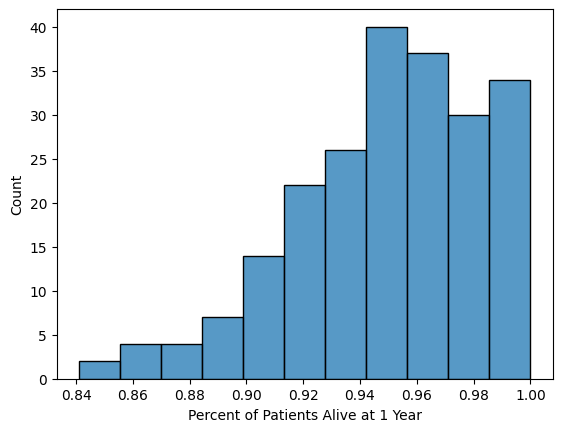

In [92]:
# separate categorical vars and non-categorical vars first
# NOT SCALED YET!!!!!!!! Only converted into proportions!!!
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS

#subset of columns from gender_outcome numericals
exog_vif = gender_outcomes[['FemaleTransplant',
 'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Total Transplants','Percent of Transplants with Functioning Graft at 30 Days', 'Percent of Patients Alive at 30 Days']].reset_index(drop=True)

# new columns of proportions rather than raw % data
exog_vif = exog_vif.assign(
Graft30 = lambda x: x['Percent of Transplants with Functioning Graft at 30 Days'] / x['Total Transplants'],
Alive30 = lambda x: x['Percent of Patients Alive at 30 Days'] / x['Total Transplants'])

exog_vif = exog_vif[['FemaleTransplant',
 'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Percent of Transplants with Functioning Graft at 30 Days', 'Percent of Patients Alive at 30 Days']].reset_index(drop=True)

#change categorical to numerical
exog_vif_dummy = pd.get_dummies(gender_outcomes, columns=['Organ', 'Donor'],
drop_first=False)

#chose specific categories
exog_vif_dummy = exog_vif_dummy[['Donor_Deceased Donor',
'Organ_Kidney','Organ_Liver','Organ_Heart']].reset_index(drop=True)

#1 fir true 0 for false
exog_vif_dummy = exog_vif_dummy.replace({True:1, False:0})
exog_vif_dummy = pd.DataFrame(exog_vif_dummy)

#combines the changed variables from categorical to numeric with the numerica from original df
exog_vif_final = pd.concat([exog_vif_dummy.reset_index(drop=True), exog_vif.reset_index(drop=True)], axis=1)

# perform VIF
print("these are VIF values: > 5 consider dropping, >10 should drop")
print(round(variance_inflation_factor(exog_vif_final, 0),2), exog_vif_final.columns[0])
print(round(variance_inflation_factor(exog_vif_final, 1),2), exog_vif_final.columns[1])
print(round(variance_inflation_factor(exog_vif_final, 2),2), exog_vif_final.columns[2])
print(round(variance_inflation_factor(exog_vif_final, 3),2), exog_vif_final.columns[3])
print(round(variance_inflation_factor(exog_vif_final, 4),2), exog_vif_final.columns[4])
print(round(variance_inflation_factor(exog_vif_final, 5),2), exog_vif_final.columns[5])
print(round(variance_inflation_factor(exog_vif_final, 6),2), exog_vif_final.columns[6])
print(round(variance_inflation_factor(exog_vif_final, 7),2), exog_vif_final.columns[7])
print(round(variance_inflation_factor(exog_vif_final, 9),2), exog_vif_final.columns[9])
print(round(variance_inflation_factor(exog_vif_final, 10),2), exog_vif_final.columns[10])
print(round(variance_inflation_factor(exog_vif_final, 11),2), exog_vif_final.columns[11])

# split the set ################################################################

# set X and y
y = gender_outcomes[[
'Percent of Transplants with Functioning Graft at 1 year',
'Percent of Patients Alive at 1 Year', 'Total Transplants']]

# rename columns in y to make the labels fit with the formula creator
X = gender_outcomes[['Donor', 'Organ',
'FemaleTransplant',
 'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Percent of Transplants with Functioning Graft at 30 Days',
'Percent of Patients Alive at 30 Days', 'Total Transplants']]

X = X.assign(
Graft30Days = lambda x: x['Percent of Transplants with Functioning Graft at 30 Days']/100,
Alive30Days = lambda x: x['Percent of Patients Alive at 30 Days']/100)

y = y.assign(
Graft1Year = lambda x: x['Percent of Transplants with Functioning Graft at 1 year']/100,
Alive1Year = lambda x: x['Percent of Patients Alive at 1 Year']/100)

y = y[['Graft1Year',
'Alive1Year']]

X = X[['Donor', 'Organ',
'FemaleTransplant',
 'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=424)

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

# scaling data
scaler = StandardScaler()
# use fit_transform for the training set (fit = teach the scaler how to scale it, transform = scale it)
X_train_scaled_subset = X_train[['FemaleTransplant',
 'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']]
X_train_scaled_subset = scaler.fit_transform(X_train_scaled_subset)
X_train_scaled_subset = pd.DataFrame(X_train_scaled_subset, columns = X_train[['FemaleTransplant',
 'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']].columns)

X_train_categorical_vars = X_train[['Donor', 'Organ']].reset_index(drop=True)
X_train = pd.concat([X_train_categorical_vars, X_train_scaled_subset], axis=1)

# use transform just transform (the already established transformation from previous step) on test set
X_test_scaled_subset = X_test[['FemaleTransplant',
 'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']]
X_test_scaled_subset = scaler.transform(X_test_scaled_subset)
X_test_scaled_subset = pd.DataFrame(X_test_scaled_subset, columns = X_test[['FemaleTransplant',
 'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']].columns)

X_test_categorical_vars = X_test[['Donor', 'Organ']].reset_index(drop=True)

X_test = pd.concat([X_test_categorical_vars, X_test_scaled_subset], axis=1)

X_train_scaled = pd.DataFrame(X_train)
X_test_scaled = pd.DataFrame(X_test)

train_frame = pd.concat([X_train_scaled.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
test_frame = pd.concat([X_test_scaled.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

# endog dsitibution check
# the dependent variable does fit the beta distribution restraint of being bound to (0,1)
sns.histplot(gender_outcomes['Percent of Patients Alive at 1 Year']/100)
(gender_outcomes['Percent of Patients Alive at 1 Year']/100).max() # 93, good!
(gender_outcomes['Percent of Patients Alive at 1 Year']/100).min() # above 0, good!

# lasso regression #############################################################
endog_array = y_train['Alive1Year'].values
endog_array2 = y_test['Alive1Year'].values

exog_array = X_train.values
# convert these to dummy variables
non_exog_dummy = X_train_scaled[['FemaleTransplant',
 'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']].reset_index(drop=True)
exog_dummy = pd.get_dummies(X_train_scaled, columns=['Donor', 'Organ'],drop_first=False)
# remove alive donor because of 1:1 collinearity
exog_dummy = exog_dummy[['Donor_Deceased Donor',
'Organ_Liver',
'Organ_Heart',
'Organ_Kidney',
'Organ_Lung']].reset_index(drop=True)
exog_dummy = exog_dummy.replace({True:1, False:0})
exog_dummy = pd.DataFrame(exog_dummy)
exog_dummy = pd.concat([exog_dummy.reset_index(drop=True), non_exog_dummy.reset_index(drop=True)], axis=1)

# add a constant
exog_dummy = sm.add_constant(exog_dummy)
exog_dummy = exog_dummy.values

# convert these to dummy variables
non_exog_dummy2 = X_test_scaled[['FemaleTransplant',
 'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']].reset_index(drop=True)
exog_dummy2 = pd.get_dummies(X_test_scaled, columns=['Donor', 'Organ'],drop_first=False)
exog_dummy2 = exog_dummy2[['Donor_Deceased Donor',
'Organ_Liver',
'Organ_Heart',
'Organ_Kidney',
'Organ_Lung']].reset_index(drop=True)
exog_dummy2 = exog_dummy2.replace({True:1, False:0})
exog_dummy2 = pd.DataFrame(exog_dummy2)
exog_dummy2 = pd.concat([exog_dummy2.reset_index(drop=True), non_exog_dummy2.reset_index(drop=True)], axis=1)

# add a constant
exog_dummy2 = sm.add_constant(exog_dummy2)
exog_dummy2 = exog_dummy2.values

lasso_original = OLS(endog_array, exog_dummy).fit_regularized(method='elastic_net', L1_wt=1.0) # not sure about the alpha param here... need to check?

params = pd.DataFrame(lasso_original.params)
params['Column'] = ['const','Donor_Deceased Donor',
'Organ_Liver',
'Organ_Heart',
'Organ_Kidney',
'Organ_Lung','FemaleTransplant',
 'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']
params['Parameters'] = params[0]
params = params[['Column', 'Parameters']]

# removing lowest variables
# keep the ones furthest from zero, negatives are OK!
params = params.assign(
Parameters = lambda x: np.absolute(x['Parameters'])
)
params.sort_values(by='Parameters', ascending=False, inplace=True)
print(params)

# create a filter threshold
param_filter = (params['Parameters'] > 0.01) # arbitraty; change to something else later?
params2 = params.loc[param_filter]
use_these_variables = list(params2['Column'])

# applying the filter ##########################################################
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

exog_array = X_train.values
# convert these to dummy variables
non_exog_dummy = X_train_scaled[['FemaleTransplant',
 'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']].reset_index(drop=True)
exog_dummy = pd.get_dummies(X_train_scaled, columns=['Donor', 'Organ'],drop_first=False)
# remove alive donor because of 1:1 collinearity
exog_dummy = exog_dummy[['Donor_Deceased Donor',
'Organ_Liver',
'Organ_Heart',
'Organ_Kidney',
'Organ_Lung']].reset_index(drop=True)
exog_dummy = exog_dummy.replace({True:1, False:0})
exog_dummy = pd.DataFrame(exog_dummy)
exog_dummy = pd.concat([exog_dummy.reset_index(drop=True), non_exog_dummy.reset_index(drop=True)], axis=1)

# add a constant
exog_dummy = sm.add_constant(exog_dummy)
exog_dummy = exog_dummy[use_these_variables]
exog_dummy = exog_dummy.values

# convert these to dummy variables
non_exog_dummy2 = X_test_scaled[['FemaleTransplant',
 'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']].reset_index(drop=True)
exog_dummy2 = pd.get_dummies(X_test_scaled, columns=['Donor', 'Organ'],drop_first=False)
exog_dummy2 = exog_dummy2[['Donor_Deceased Donor',
'Organ_Liver',
'Organ_Heart',
'Organ_Kidney',
'Organ_Lung']].reset_index(drop=True)
exog_dummy2 = exog_dummy2.replace({True:1, False:0})
exog_dummy2 = pd.DataFrame(exog_dummy2)
exog_dummy2 = pd.concat([exog_dummy2.reset_index(drop=True), non_exog_dummy2.reset_index(drop=True)], axis=1)

# add a constant
exog_dummy2 = sm.add_constant(exog_dummy2)
exog_dummy2 = exog_dummy2[use_these_variables]
exog_dummy2 = exog_dummy2.values

endog_array = y_train['Alive1Year'].values
endog_array2 = y_test['Alive1Year'].values

# beta regression ##############################################################

gender_model_final = BetaModel(endog_array, exog_dummy)
result_gender_final = gender_model_final.fit()
print(result_gender_final.summary)
y_pred = result_gender_final.predict(exog_dummy2)
mse = mean_squared_error(endog_array2, y_pred)
print(mse) # what????? it works well???????????


In [87]:
use_these_variables

['const',
 'Organ_Lung',
 'Alive30Days',
 'Donor_Deceased Donor',
 'Organ_Kidney',
 'Organ_Liver',
 'Organ_Heart']

In [95]:
exog_dummy

array([[ 1.        ,  0.        ,  0.63943331, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.        , -0.53335098, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.        ,  0.        , -3.01118846, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.        ,  1.        , -1.38868989, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.38371343, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.12799355, ...,  1.        ,
         0.        ,  0.        ]])